In [1]:
import chipwhisperer as cw
import matplotlib.pyplot as plt
import numpy as np

import simon_64_128
import simon_64_128_simulation

from helper import KeyHypothesis
import helper
import correlations

from measurement import Measurements, Measurement

/home/nico/miniconda3/envs/simon/lib/python3.13/site-packages/chipwhisperer/capture/trace/TraceWhisperer.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources # type: ignore


# Import Trace

In [2]:
project = cw.import_project("./traces/07_simon_plain_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/10_simon_masked_50000/trace.zip", overwrite=True)
# project = cw.import_project("./traces/12_simon_masked_50000/trace.zip", overwrite=True)

In [29]:
TOTAL_NUM_MEASUREMENTS = len(project.traces)
TOTAL_VALS_PER_MEASUREMENT = len(project.traces[0].wave)

NUM_MEASUREMENTS = 500
VALS_PER_MEASUREMENT = 1000

# Transform Trace Project into Measurement object

In [31]:
%matplotlib widget

plaintexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
ciphertexts = np.zeros((TOTAL_NUM_MEASUREMENTS, 2), dtype=np.uint32)
powers = np.zeros((TOTAL_NUM_MEASUREMENTS, TOTAL_VALS_PER_MEASUREMENT), dtype=np.uint32)

for i, trace in enumerate(project.traces):

    pt = trace.textin
    ct = trace.textout

    plaintexts[i,0] = pt[0] << 24 | pt[1] << 16 | pt[2] << 8 | pt[3]
    plaintexts[i,1] = pt[4] << 24 | pt[5] << 16 | pt[6] << 8 | pt[7]

    ciphertexts[i,0] = ct[0] << 24 | ct[1] << 16 | ct[2] << 8 | ct[3]
    ciphertexts[i,1] = ct[4] << 24 | ct[5] << 16 | ct[6] << 8 | ct[7]
    powers[i,:] = trace.wave

all_measurements = Measurements(plaintexts, ciphertexts, powers)
measurements = Measurements(plaintexts[0:NUM_MEASUREMENTS], ciphertexts[0:NUM_MEASUREMENTS], powers[0:NUM_MEASUREMENTS, 0:VALS_PER_MEASUREMENT])


In [5]:
# key = np.array([0x19013660, 0x86de7696, 0xd0427aff, 0x738dd98a], dtype=np.uint32)
# key = np.array([0x1B1A1918, 0x13121110, 0x0B0A0908, 0x03020100], dtype=np.uint32)
key = np.array([0x8dcc04b1, 0xad004534, 0x8afa7151, 0xf173d6d7], dtype=np.uint32) # measurement 07_simon_plain_50000
# key = np.array([0xb057096b, 0x07872546, 0xae7fe580, 0x5fbc809f], dtype=np.uint32) # measurement 10_simon_masked_50000
# key = np.array([0xbae7cfb7, 0xb9285666, 0x70c74f9c, 0x146c0f4c], dtype=np.uint32) # measurement 11_simon_masked_50000
# key = np.array([0x4f841273, 0xe61edffd, 0xc5c5c70e, 0xe90722f5], dtype=np.uint32) # temp measurement
# key = np.array([0xad828bc8, 0x3bada07c, 0xc80bf12f, 0x75c03156], dtype=np.uint32) # t-test

pt = measurements[0].plaintext
ct = measurements[0].ciphertext

ct_expect, _ = simon_64_128.encrypt_block(pt, key)

print(hex(pt[0]), hex(pt[1]))
print(hex(ct[0]), hex(ct[1]))
print(hex(ct_expect[0]), hex(ct_expect[1]))

0xbcb9de18 0xa2a678b4
0x71848ecc 0x51fe6a06
0x71848ecc 0x51fe6a06


In [32]:
print(all_measurements.plaintext.shape)
print(all_measurements.ciphertext.shape)
print(all_measurements.power.shape)

print(measurements.plaintext.shape)
print(measurements.ciphertext.shape)
print(measurements.power.shape)

(50000, 2)
(50000, 2)
(50000, 5000)
(500, 2)
(500, 2)
(500, 1000)


# Attacking X after Add Round Key

In [34]:
ATTACKED_STATE = "ADD_ROUND_KEY"
GUESSED_BITS_PER_STEP = 8
CORR_DIFF_THRESHOLD = 0.02

# start with empty key as hypothesis as root for the search tree
empty_key = np.zeros((4,), dtype=np.uint32)
empty_mask = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, empty_mask)

# variables to maintain during attack
promising_hypos = [start_hypo]
guessed_bits_mask = np.zeros((4,), dtype=np.uint32)

for attacked_round in range(4):
    print(f"Start attacking round {attacked_round}.")
    num_guessed_bits = 0
    while True:
        if guessed_bits_mask[3- attacked_round] == 0xFFFFFFFF:
            print(f"Finished attacking round {attacked_round}. {len(promising_hypos)} promising hypotheses left.")
            break
        else:
            # Add newly guessed bits to the mask.
            for i in range(num_guessed_bits, num_guessed_bits + GUESSED_BITS_PER_STEP):
                guessed_bits_mask[3 - attacked_round] |= (1 << i)
            num_guessed_bits += GUESSED_BITS_PER_STEP
        print(f"- Perform CPA on {helper.bits_count(guessed_bits_mask[3 - attacked_round])} guessed bits.")

        # Generate sub hypotheses for all previously identified promising hypotheses
        sub_hypos: list[KeyHypothesis] = []
        for h in promising_hypos:
            sub_hypos.extend(h.get_sub_hypos(guessed_bits_mask))

        print(f"- Find correlations for {len(sub_hypos)} hypotheses.")
        helper.calc_corrs_for_hypos(sub_hypos, measurements, attacked_round, ATTACKED_STATE)
        promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

        print(f"- Found {len(promising_hypos)} promising hypotheses:")
        for hypo in promising_hypos:
            print(f"  - {helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

key_found = False
if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            key_found = True
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
    
if not key_found:
    print("Could not determine key")

Start attacking round 0.
- Perform CPA on 8 guessed bits.
- Find correlations for 256 hypotheses.
- Found 6 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0x00000028: correlation: 0.4164112525618412
  - 0x00000000 0x00000000 0x00000000 0x00000078: correlation: 0.4090666261632022
  - 0x00000000 0x00000000 0x00000000 0x00000079: correlation: 0.4142643677379775
  - 0x00000000 0x00000000 0x00000000 0x00000086: correlation: -0.41426436773797726
  - 0x00000000 0x00000000 0x00000000 0x00000087: correlation: -0.4090666261632028
  - 0x00000000 0x00000000 0x00000000 0x000000D7: correlation: -0.4164112525618409
- Perform CPA on 16 guessed bits.
- Find correlations for 1536 hypotheses.
- Found 2 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0x00002928: correlation: 0.6381215225781652
  - 0x00000000 0x00000000 0x00000000 0x0000D6D7: correlation: -0.638121522578165
- Perform CPA on 24 guessed bits.
- Find correlations for 512 hypotheses.
- Found 2 promising hypotheses:
  - 0

# Attacking X after AND-Gate

In [ ]:
ATTACKED_STATE = "AND_GATE"
GUESSED_BITS_PER_STEP = 8
CORR_DIFF_THRESHOLD = 0.03

# start with empty key as hypothesis as root for the search tree
empty_key = np.zeros((4,), dtype=np.uint32)
empty_mask = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, empty_mask)

# variables to maintain during attack
promising_hypos = [start_hypo]
guessed_bits_mask = np.zeros((4,), dtype=np.uint32)

for attacked_round in range(4):
    print(f"Start attacking round {attacked_round}.")
    num_guessed_bits = 0
    while True:
        if guessed_bits_mask[3- attacked_round] == 0xFFFFFFFF:
            print(f"Finished attacking round {attacked_round}. {len(promising_hypos)} promising hypotheses left.")
            break
        else:
            # Add newly guessed bits to the mask. Place the bits in distance of 7 to each other
            for i in range(num_guessed_bits, num_guessed_bits + GUESSED_BITS_PER_STEP):
                bit_pos = i*7 % 32
                guessed_bits_mask[3 - attacked_round] |= (1 << bit_pos)
            num_guessed_bits += GUESSED_BITS_PER_STEP

        print(f"- Perform CPA on {helper.bits_count(guessed_bits_mask[3 - attacked_round])} guessed bits.")

        # Generate sub hypotheses for all previously identified promising hypotheses
        sub_hypos: list[KeyHypothesis] = []
        for h in promising_hypos:
            sub_hypos.extend(h.get_sub_hypos(guessed_bits_mask))

        print(f"- Find correlations for {len(sub_hypos)} hypotheses.")
        helper.calc_corrs_for_hypos(sub_hypos, measurements, attacked_round, ATTACKED_STATE)
        promising_hypos = helper.filter_hypos(sub_hypos, CORR_DIFF_THRESHOLD)

        print(f"- Found {len(promising_hypos)} promising hypotheses:")
        for hypo in promising_hypos:
            print(f"  - {helper.array_to_hex_str(hypo.key)}: correlation: {hypo.corr}")

key_found = False
if len(promising_hypos) > 0:
    # Do final check against ciphertext
    for hypo in promising_hypos:
        ciphertext, _ = simon_64_128.encrypt_block(measurements[0].plaintext, hypo.key)
        if np.array_equal(measurements[0].ciphertext, ciphertext):
            extracted_key = hypo.key
            key_found = True
            print(f"Extracted Key: {helper.array_to_hex_str(extracted_key)}")
            break
    
if not key_found:
    print("Could not determine key")

Start attacking round 0.
- Perform CPA on 8 guessed bits.
- Find correlations for 256 hypotheses.
- Found 2 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0x10224480: correlation: -0.517069633805982
  - 0x00000000 0x00000000 0x00000000 0x10224481: correlation: -0.5355685115144417
- Perform CPA on 16 guessed bits.
- Find correlations for 512 hypotheses.
- Found 1 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0x913246C5: correlation: -0.6229855679257185
- Perform CPA on 24 guessed bits.
- Find correlations for 256 hypotheses.
- Found 1 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0xD13356C7: correlation: -0.7386682851549509
- Perform CPA on 32 guessed bits.
- Find correlations for 256 hypotheses.
- Found 4 promising hypotheses:
  - 0x00000000 0x00000000 0x00000000 0xF173D6C7: correlation: -0.8257125229072785
  - 0x00000000 0x00000000 0x00000000 0xF173D6D7: correlation: -0.8417511248872095
  - 0x00000000 0x00000000 0x00000000 0xF373D6C7: correlation:

# Attack Insights
## Correlation over Time for one guessed byte
### State: After Add round key

(256, 5000)


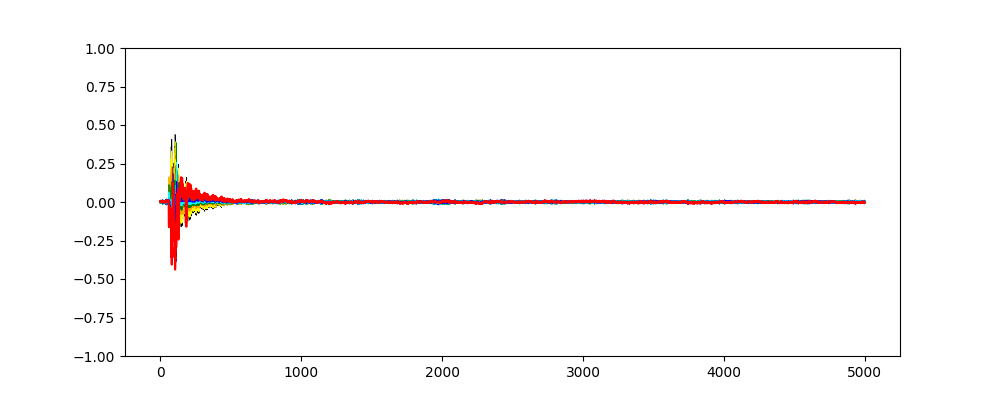

In [9]:
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)


expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF),
        "ADD_ROUND_KEY"
)

corrs = correlations.calc_corrs(expected_hws, all_measurements.power)
print(corrs.shape)

colors = ["red", "black", "brown", "blue", "cyan", "green", "orange", "yellow", "black"]
correct_byte = int(key[3] & 0xFF)

plt.figure(figsize=(10,4))
for i in range(256):
    color_idx = int.bit_count(i ^ correct_byte)
    color = colors[color_idx]
    # color = "black"

    plt.plot(corrs[i], color=color, linewidth=0.5)

plt.plot(corrs[correct_byte], color="red")

plt.ylim(-1, 1)
plt.show()

### State: After AND-Gate

(256, 5000)


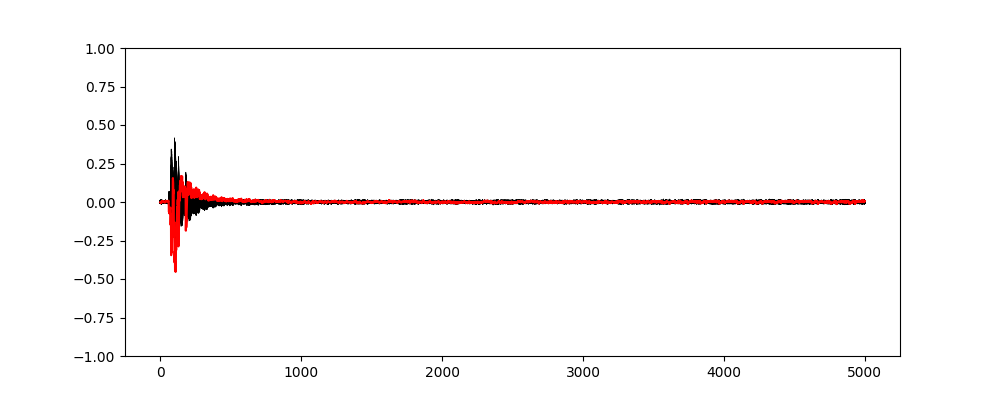

In [10]:
# start with empty key as hypothesis as root for the search tree
empty_key = np.zeros((4,), dtype=np.uint32)
empty_mask = np.zeros((4,), dtype=np.uint32)
start_hypo = KeyHypothesis(empty_key, empty_mask)

KEY_MASK = np.array([0,0,0,0b00010000001000100100010010001001], dtype=np.uint32)


# guess 8 bits with a distance of 7
hypos = start_hypo.get_sub_hypos(KEY_MASK)
guessed_keys = np.array([h.key for h in hypos], dtype=np.uint32)

STATE_MASK = (KEY_MASK[3] << 1) & (KEY_MASK[3] << 8)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        0, 
        STATE_MASK,
        "AND_GATE"
)

corrs = correlations.calc_corrs(expected_hws, all_measurements.power)
print(corrs.shape)

correct_guess = int(key[3] & KEY_MASK[3])
correct_guess_idx = np.where(guessed_keys[:,3] == correct_guess)[0][0]

plt.figure(figsize=(10,4))
for i in range(256):
    plt.plot(corrs[i], color="black", linewidth=0.5)

plt.plot(corrs[correct_guess_idx], color="red")

plt.ylim(-1, 1)
plt.show()


(256, 5000)


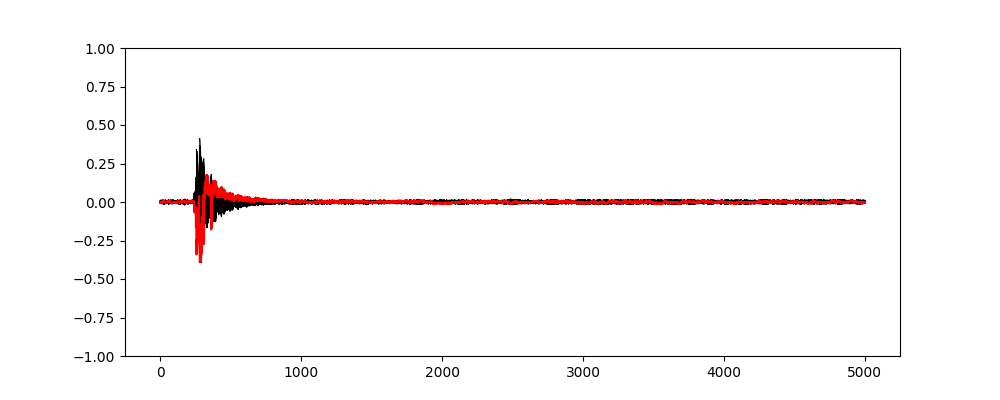

In [11]:
start_hypo = KeyHypothesis(
    np.array([0, 0xAD004524, 0x8AFA7151, 0xF173D6D7], dtype=np.uint32), 
    np.array([0, 0xFFFFFFFF, 0xFFFFFFFF, 0xFFFFFFFF], dtype=np.uint32)
)

KEY_MASK = np.array([0b00010000001000100100010010001001, 0xFFFFFFFF, 0xFFFFFFFF, 0xFFFFFFFF], dtype=np.uint32)

# guess 8 bits with a distance of 7
hypos = start_hypo.get_sub_hypos(KEY_MASK)
guessed_keys = np.array([h.key for h in hypos], dtype=np.uint32)

STATE_MASK = (KEY_MASK[0] << 1) & (KEY_MASK[0] << 8)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        3, 
        STATE_MASK,
        "AND_GATE"
)

corrs = correlations.calc_corrs(expected_hws, all_measurements.power)
print(corrs.shape)

correct_guess = int(key[0] & KEY_MASK[0])
correct_guess_idx = np.where(guessed_keys[:,0] == correct_guess)[0][0]

plt.figure(figsize=(10,4))
for i in range(256):
    plt.plot(corrs[i], color="black", linewidth=0.5)

plt.plot(corrs[correct_guess_idx], color="red")

plt.ylim(-1, 1)
plt.show()


In [12]:
order = np.argsort(np.max(np.abs(corrs), axis=1))[::-1]
for idx in order[:10]:
    if np.max(corrs[idx]) > -np.min(corrs[idx]):
        highest = np.max(corrs[idx])
    else:
        highest = np.min(corrs[idx])
    print(f"{idx}:\t {guessed_keys[idx, 0]:032b} (correlation: {highest})")

print(f":\t {guessed_keys[correct_guess_idx, 0]:032b}")

242:	 00010000001000100100000000001000 (correlation: 0.41432283410218496)
109:	 00000000001000100000010010000001 (correlation: -0.3950482152280191)
13:	 00000000000000000000010010000001 (correlation: -0.39076067906559314)
77:	 00000000001000000000010010000001 (correlation: -0.3714986581262076)
243:	 00010000001000100100000000001001 (correlation: 0.36885837244468433)
45:	 00000000000000100000010010000001 (correlation: -0.35848618579820457)
15:	 00000000000000000000010010001001 (correlation: -0.3552931146479037)
240:	 00010000001000100100000000000000 (correlation: 0.35164421500897586)
108:	 00000000001000100000010010000000 (correlation: -0.3513396507249273)
12:	 00000000000000000000010010000000 (correlation: -0.34889599956474504)
:	 00000000000000000000010010000001


In [13]:
%matplotlib widget
guessed_keys = np.zeros((256,4), dtype=np.uint32)
guessed_keys[:, 3] = np.arange(256)

expected_hws = simon_64_128_simulation.get_hws_for_guessed_keys(
        all_measurements.plaintext,
        guessed_keys, 
        0, 
        np.uint32(0xFF),
        "AND_GATE"
)
print(expected_hws.shape)

corrs = correlations.Corr((256,TOTAL_VALS_PER_MEASUREMENT))

di = 50
best_corrs_over_num_measurements = np.zeros((256,TOTAL_NUM_MEASUREMENTS//di), dtype=np.float64)

n = 10
for i in range(0,TOTAL_NUM_MEASUREMENTS, n):
    corrs.update(expected_hws[i:i+n,:], all_measurements.power[i:i+n,:]) 
    if i % di == 0:
        idx = i // di
        best_corrs_over_num_measurements[:, idx] = corrs.max(axis=1)


(50000, 256)


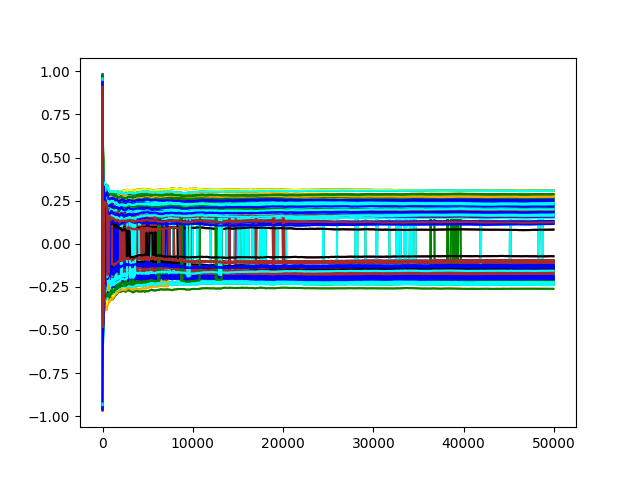

In [14]:
%matplotlib widget

plt.figure()
x = np.arange(0, TOTAL_NUM_MEASUREMENTS, step=di)

colors = ["red", "black", "brown", "blue", "cyan", "green", "orange", "yellow", "black"]
correct_byte = int(key[3] & 0xFF)

for i in range(256):
    color_idx = int.bit_count(i ^ correct_byte)
    color = colors[color_idx]
    plt.plot(x, best_corrs_over_num_measurements[i], color=color)

plt.show()